# Bias on Wikipedia

For this assignment (https://wiki.communitydata.cc/HCDS_(Fall_2017)/Assignments#A2:_Bias_in_data), your job is to analyze what the nature of political articles on Wikipedia - both their existence, and their quality - can tell us about bias in Wikipedia's content.

# Data Acquisition 

The first source of our data is the Wikipedia data for politicians by their country and the Revision ID of the latest edit of the Wikipedia article on them. This data can be downloaded at https://figshare.com/articles/Untitled_Item/5513449

We download this data and read the csv (page_data.csv) present in country/data folder from the downloaded ZIP.

In [2]:
## getting the data from the CSV files and converting into a list
import csv
import pandas as pd

data = []
with open('page_data.csv', encoding='utf8') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        data.append([row[0],row[1],row[2]])

The next source of our data is ORES API: https://ores.wikimedia.org/v3/scores/{project}/{revid}/{model}
This API gives the quality of the Wikipedia article as shown here

In [5]:
import requests
import json

#The endpoint for ORES API
endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/{revid}/{model}'
headers = {'User-Agent' : 'https://github.com/SalikWarsi', 'From' : 'salikw@uw.edu'}

params = {'project' : 'enwiki',
          'model' : 'wp10',
          'revid' : '797882120'
          }

api_call = requests.get(endpoint.format(**params))
response = api_call.json()
print(json.dumps(response, indent=4, sort_keys=True))

{
    "enwiki": {
        "models": {
            "wp10": {
                "version": "0.5.0"
            }
        },
        "scores": {
            "797882120": {
                "wp10": {
                    "score": {
                        "prediction": "Start",
                        "probability": {
                            "B": 0.0325056273665757,
                            "C": 0.10161634736900718,
                            "FA": 0.003680032854794337,
                            "GA": 0.021044772033944954,
                            "Start": 0.8081343649161963,
                            "Stub": 0.033018855459481376
                        }
                    }
                }
            }
        }
    }
}


We can query this API and parse the JSON response to get the predicted Quality Score of the revision edit from ORES as shown next

In [6]:
endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/{revid}/{model}'
headers = {'User-Agent' : 'https://github.com/SalikWarsi', 'From' : 'salikw@uw.edu'}

params = {'project' : 'enwiki',
          'model' : 'wp10',
          'revid' : '797882120'
          }

response = requests.get(endpoint.format(**params))
json_data = json.loads(response.text)
print(json_data['enwiki']['scores'][params['revid']]['wp10']['score']['prediction'])

Start


Now we read the CSV we read earlier and for each of the Revision Ids in that table we query the ORES API and after parsing the JSON store the result (Quality) in a new list. 

Finally we combine all the data into a pandas data frame and write it to a csv file: **en-wikipedia_politician_article.csv** 

**Note: This takes hours to run so be careful running it.** The stored CSV file is there so we can directly start after this step. This is also why I put it under try-except as I was occaisonally getting an error. However the stored CSV file does contain all the data

In [8]:
#Now we read each data from csv row (except the first which is the header) 
#and query the ORES service for Quality score finally converting it into a csv
countries, politicians, revids, quality = [], [], [], []

rowcount = 0
for row in data[1:]:
    try:
        # We call the ORES API with the revision ID
        params = {'project' : 'enwiki',
              'model' : 'wp10',
              'revid' : row[2]
              }
        response = requests.get(endpoint.format(**params))
        json_data = json.loads(response.text)
        #This step parses the JSON and extracts the score and adds it to the list
        quality.append(json_data['enwiki']['scores'][params['revid']]['wp10']['score']['prediction'])
        countries.append(row[0])
        politicians.append(row[1])
        revids.append(row[2])
        rowcount = rowcount+1
        if(rowcount % 10 == 0):
            print(rowcount)
    except:
        rowcount = rowcount+1
        print("Exception Occured", rowcount)
#Write to a file
#First convert to data frame

print("Writing to File")
dataFrame = pd.DataFrame([countries, politicians, revids, quality]).T
dataFrame.columns = ["country", "politician", "revid", "quality"]

#Write Data frame to csv
dataFrame.to_csv('en-wikipedia_politician_article.csv',index=False)
print("Written")

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
1717

29170
29180
29190
29200
29210
29220
29230
29240
29250
29260
29270
29280
29290
29300
29310
29320
29330
29340
29350
29360
29370
29380
29390
29400
29410
29420
29430
29440
29450
29460
29470
29480
29490
29500
29510
29520
29530
29540
29550
29560
29570
29580
29590
29600
29610
29620
29630
29640
29650
29660
29670
29680
29690
29700
29710
29720
29730
29740
29750
29760
29770
29780
29790
29800
29810
29820
29830
29840
29850
29860
29870
29880
29890
29900
29910
29920
29930
29940
29950
29960
29970
29980
29990
30000
30010
30020
30030
30040
30050
30060
30070
30080
30090
30100
30110
30120
30130
30140
30150
30160
30170
30180
30190
30200
30210
30220
30230
30240
30250
30260
30270
30280
30290
30300
30310
30320
30330
30340
30350
30360
30370
30380
30390
30400
30410
30420
30430
30440
30450
30460
30470
30480
30490
30500
30510
30520
30530
30540
30550
30560
30570
30580
30590
30600
30610
30620
30630
30640
30650
30660
30670
30680
30690
30700
30710
30720
30730
30740
30750
30760
30770
30780
30790
30800
30810
30820
3083

42830
42840
42850
42860
42870
42880
42890
42900
42910
42920
42930
42940
42950
42960
42970
42980
42990
43000
43010
43020
43030
43040
43050
43060
43070
43080
43090
43100
43110
43120
43130
43140
43150
43160
43170
43180
43190
43200
43210
43220
43230
43240
43250
43260
43270
43280
43290
43300
43310
43320
43330
43340
43350
43360
43370
43380
43390
43400
43410
43420
43430
43440
43450
43460
43470
43480
43490
43500
43510
43520
43530
43540
43550
43560
43570
43580
43590
43600
43610
43620
43630
43640
43650
43660
43670
43680
43690
43700
43710
43720
43730
43740
43750
43760
43770
43780
43790
43800
43810
43820
43830
43840
43850
43860
43870
43880
43890
43900
43910
43920
43930
43940
43950
43960
43970
43980
43990
44000
44010
44020
44030
44040
44050
44060
44070
44080
44090
44100
44110
44120
44130
44140
44150
44160
44170
44180
44190
44200
44210
44220
44230
44240
44250
44260
44270
44280
44290
44300
44310
44320
44330
44340
44350
44360
44370
44380
44390
44400
44410
44420
44430
44440
44450
44460
44470
44480
4449

The Third data source is the Population data by Country from the Population Referece Bureau: http://www.prb.org/DataFinder/Topic/Rankings.aspx?ind=14

It can be downlaoded directly from that website using the Excel button on top right. This is stored as: **Population Mid-2015.csv**

# Data Processing

We now have 2 csv files that we will combine and clean. These are
1. en-wikipedia_politician_article.csv
2. Population Mid-2015.csv

In [6]:
#Reading Politician article data
Politicians = pd.read_csv('en-wikipedia_politician_article.csv')

#Reading Population CSV. Here the first line is not part of the table so we skip it
# Also by defining the separartor and thousands we read the population as an integer
Population = pd.read_csv('Population Mid-2015.csv', header=1, sep= ",", thousands=',')

# Keeping only the columns we need: country and data (Population of the country in mid 2015)
Population = Population[['Location', 'Data']]

# We combine the 2 data sets
# We use an inner join as we only want those rows where we have data from both tables
Combined = Politicians.merge(Population, left_on='country', right_on='Location', how='inner')

Here we notice that some politicians are part o multiple countries. However itis possible that 2 different people have the same name. Therefore we use Revision ID of the wikipedia article as a unique identifier. 

We count number of rows per Revision ID and we only take those revision ids that have 1 row. Then we do an inner join to only include those which are unique

In [7]:
# Counting rows per Revision ID
rowsPerPolitician = pd.DataFrame({'count' : Combined.groupby( ['revid'] ).size()}).reset_index()

#Only keeping those revision ID with 1 row only
uniquePoliticians = rowsPerPolitician[rowsPerPolitician['count'] == 1]

#Merging with Combined with an inner join to keep only unique politicians
Combined = Combined.merge(uniquePoliticians, left_on='revid', right_on='revid', how='inner')


Finally we extract only the columns we need and rename them before writing to a csv file: **PoliticiansArticleQualityWithCountryPopulation.csv**

In [8]:
Combined = Combined[['country', 'politician', 'revid', 'quality', 'Data']]
Combined.columns = ['country', 'article_name', 'revision_id', 'article_quality', 'population']

Combined.to_csv('PoliticiansArticleQualityWithCountryPopulation.csv',index=False, encoding='utf8')

# Data Analysis

The first thing we do is read the data into a panda dataframe

In [9]:
data = pd.read_csv('PoliticiansArticleQualityWithCountryPopulation.csv', encoding='utf8')

Now we try to find number of Politician Articles divided by the population of the country for each country.
As earlier during data processing we have removed any article that exists more than once, by counting the number of rows in our data set per country we get number of Politician Articles for that country.

Similarly we could find the mean population value per country as for each country we already have a unique population value.

In [12]:
articlesPerCountry = pd.DataFrame({'articles' : data.groupby( ['country'] ).size(),
                               'population' : data.groupby( ['country'] )['population'].mean()}).reset_index()

# Find the ratio of Articles per Population
articlesPerCountry['PoliticianArticlesPerPopulation'] = articlesPerCountry['articles'] / articlesPerCountry['population']



In [13]:
# We now sort the data according this calculated ratio
articlesPerCountry.sort_values(by='PoliticianArticlesPerPopulation', ascending=False, inplace=True)

Now as its sorted in descending order we take the first 10 values as the top 10 ratios and plot a bar chart

Populating the interactive namespace from numpy and matplotlib


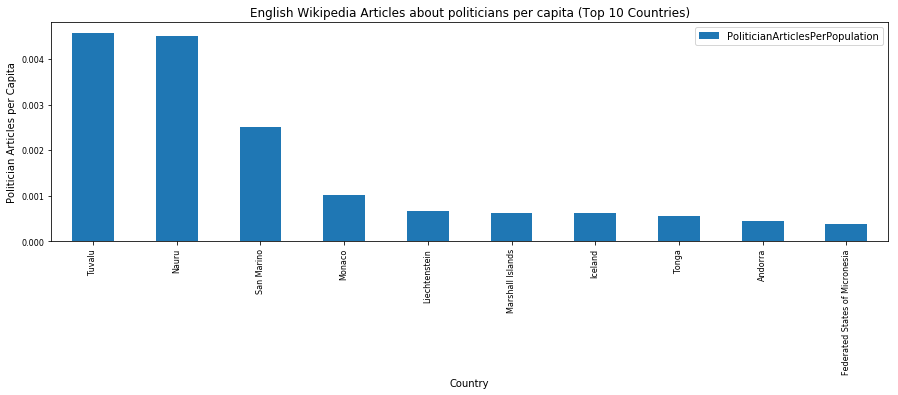

In [17]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)

#Taking top 10 values
articlesPerCountryTop = articlesPerCountry[:10]

#Creating plot
articlesPerCountryTop.plot.bar(x='country', y = 'PoliticianArticlesPerPopulation',fontsize = 8)
plt.subplots_adjust(bottom=0.5)
plt.xlabel('Country')  # Add a label to the x-axis
plt.ylabel('Politician Articles per Capita')  # Add a label to the y-axis
plt.title('English Wikipedia Articles about politicians per capita (Top 10 Countries)')  # Add a plot title
plt.savefig('Top10ArticlesPerCapita.png')
plt.show()

Similarly we create a barchart for the bottom 10 countries for that ratio

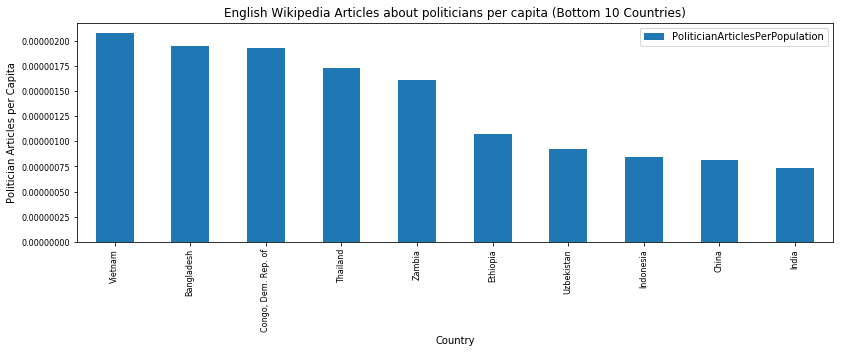

In [18]:
articlesPerCountryBottom = articlesPerCountry[-10:]

articlesPerCountryBottom.plot.bar(x='country', y = 'PoliticianArticlesPerPopulation',fontsize = 8)
plt.subplots_adjust(bottom=0.5,left=0.2)
plt.xlabel('Country')  # Add a label to the x-axis
plt.ylabel('Politician Articles per Capita')  # Add a label to the y-axis
plt.title('English Wikipedia Articles about politicians per capita (Bottom 10 Countries)')  # Add a plot title


plt.savefig('Bottom10ArticlesPerCapita.png')
plt.show()

### Analysis

We can see the highest ranked countries for those are some of the smallest countries in population while most of the countries at the bottom of this ranking have a high population. Even so countries like USA which have a very high population (3rd highest) still don't figure at the very bottom while some countries like Uzbekistan ( which has a realtively small population) still have a very low ratio. This could indicate bias against countries like Uzbekistan indicating that they might have lesser number of politicains listed in English Wikipedia than they should.

However it is important to note that the size of a country's parliament (or other governing body) which might indicate number of famous politicians is not directly proportional to their population. For example Tuvalu's population is less than 12000 while that of India is more 1.2 billion. However, as seen in https://en.wikipedia.org/wiki/Parliament_of_Tuvalu while their parliament has 15 members, India's doesn't have 150,000 members of parliaments. This could indicate why smaller countries tend to have higher ratios.

## Quality Articles

We then say that a article is high quality if it's quality rating is **FA** or **GA**.

Then for each country we calculate how much proportion of the articles are highquality and we plot the top 10 and the bottom 10.

We first create a new Variable in our data that denotes this articles is high quality

In [19]:
data['IsHighQuality'] = (data['article_quality'] == 'FA') | (data['article_quality'] == 'GA')

We then calculate the proportion of articles which are high quality for each country and we sort by this proportion. We use population of the country to break ties.

In [21]:
qualityPerCountry = pd.DataFrame({'population' : data.groupby( ['country'] )['population'].mean(),
                                  'HighQualityProportion' : data.groupby( ['country'] )['IsHighQuality'].mean()}).reset_index()
qualityPerCountry.sort_values(by=['HighQualityProportion', 'population'], ascending=[False,True], inplace=True)

Now we take the top 10 and plot a bar chart

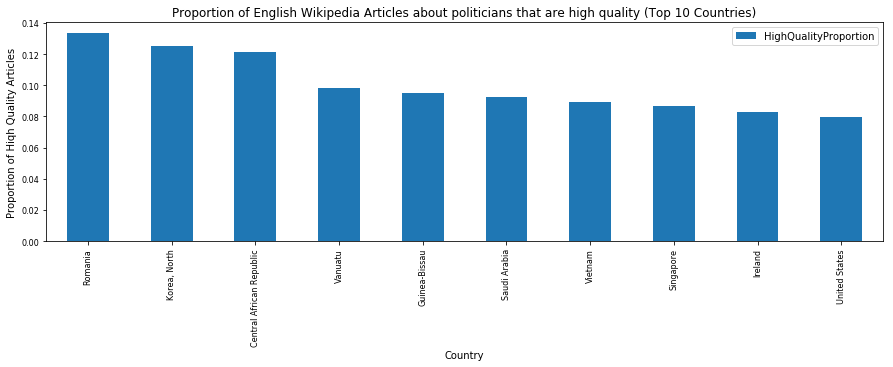

In [23]:
qualityPerCountryTop = qualityPerCountry[:10]

qualityPerCountryTop.plot.bar(x='country', y = 'HighQualityProportion',fontsize = 8)
plt.subplots_adjust(bottom=0.5)
plt.xlabel('Country')  # Add a label to the x-axis
plt.ylabel('Proportion of Hiqh Quality Articles')  # Add a label to the y-axis
plt.title('Proportion of English Wikipedia Articles about politicians that are high quality (Top 10 Countries)')  # Add a plot title


plt.savefig('Top10QualityArticleRatio.png')
plt.show()

Instead of showing a barchart, I observed that 39 countries have 0 High Quality articles about their politicians.
These are listed here

In [25]:
bottomCountries = qualityPerCountry[qualityPerCountry['HighQualityProportion'] == 0 ]
print(bottomCountries)

                            country  HighQualityProportion  population
119                           Nauru                    0.0       10860
171                          Tuvalu                    0.0       11800
140                      San Marino                    0.0       33000
112                          Monaco                    0.0       38088
45                         Dominica                    0.0       68000
3                           Andorra                    0.0       78000
5               Antigua and Barbuda                    0.0       90000
144                      Seychelles                    0.0       92833
53   Federated States of Micronesia                    0.0      103000
63                          Grenada                    0.0      111000
84                         Kiribati                    0.0      113400
57                    French Guiana                    0.0      251000
14                         Barbados                    0.0      278000
17    

### Analysis

Here we see that while for some countries almost 1/8th of the articles about their politicians have a high quality, for many others there are 0 articles that have a high quality. This indicates the imbalance in coverage in English Wikipedia articles and shows bias

# Possible Issues
There could be some issues in this analysis. As shown in https://figshare.com/articles/Untitled_Item/5513449 only 1 level of nesting was used to get Wikipedia articles from English Wikipedia. This might have led to us missing some articles and therefore corrupted our analysis.

Also when joining using countries between the data sources some countries had minor difference in names, which meant that they were removed from the analysis.